# Example DESeq2 Analysis

## Install libraries required for analysis:

In [48]:
# Load the package
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
    
BiocManager::install("DESeq2", version = "3.14")

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cloud.r-project.org


Bioconductor version 3.14 (BiocManager 1.30.16), R 4.1.2 (2021-11-01)

Warning message:
“package(s) not installed when version(s) same as current; use `force = TRUE` to
  re-install: 'DESeq2'”
Installation paths not writeable, unable to update packages
  path: /usr/lib/R/library
  packages:
    class, foreign, MASS, Matrix, mgcv, nlme, nnet, rpart, spatial, survival
  path: /usr/local/lib/R/site-library
  packages:
    commonmark, desc, openssl, Rcpp, rlang, rmarkdown, withr, xfun



## Import libraries required for analysis:

In [149]:
# Load the package
library(bigrquery)
library("DESeq2")
library(ggplot2)
library(tidyverse) 

## Create DESeq2 Count DF

In [150]:
# Store the project ID
projectid = "aadev-2342"

# Set your query
sql <- "SELECT sample_id, gene_id, expected_count FROM `aadev-2342.rnaseq_nf_gene_results.GRCh38_2020_A`"

# Run the query and store the data in a tibble
tb <- bq_project_query(projectid, sql)

# Print 10 rows of the data
bq_table_download(tb, n_max = 10)

sample_id,gene_id,expected_count
<chr>,<chr>,<dbl>
SRR15594009,ENSG00000050327_ARHGEF5,0
SRR15594009,ENSG00000089012_SIRPG,0
SRR15594009,ENSG00000092345_DAZL,0
SRR15594009,ENSG00000100249_C22orf31,0
SRR15594009,ENSG00000101323_HAO1,0
SRR15594009,ENSG00000102290_PCDH11X,0
SRR15594009,ENSG00000107807_TLX1,0
SRR15594009,ENSG00000109205_ODAM,0
SRR15594009,ENSG00000112186_CAP2,0


In [151]:
deseq2_count_data <- bq_table_download(tb) %>% pivot_wider(names_from=sample_id, values_from=expected_count, values_fill=0)

In [152]:
deseq2_count_data <- as.data.frame(deseq2_count_data)

In [153]:
deseq2_count_data <- deseq2_count_data %>% mutate_at(vars(-gene_id), funs(round(., 0)))

In [154]:
deseq2_count_data <- deseq2_count_data[, order(colnames(deseq2_count_data))]

In [155]:
head(deseq2_count_data)

,gene_id,SRR15594007,SRR15594008,SRR15594009,SRR15594010,SRR15594011,SRR15594012,SRR15594013
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000050327_ARHGEF5,6,0,0,0,0,33,6
2,ENSG00000089012_SIRPG,2,0,0,0,0,0,0
3,ENSG00000092345_DAZL,18,0,0,5,2,0,0
4,ENSG00000100249_C22orf31,5,1,0,1,0,0,0
5,ENSG00000101323_HAO1,0,0,0,0,0,0,0
6,ENSG00000102290_PCDH11X,0,0,0,0,0,4,0


## Create DESeq2 Metadata DF
### Metadata is available at link [here](https://www.ncbi.nlm.nih.gov/Traces/study/?acc=PRJNA757274&o=acc_s%3Aa):
* Click download metadata button boxed in red

<!-- <img src="img/PRJNA757274_SRA_Run_Selector_With_Red_Box.png" width=1300 height=1300 /> -->

In [192]:
deseq2_meta_data <- read.csv(file='data/PRJNA757274_SraRunTable.txt', header=TRUE, sep = ",")

In [193]:
deseq2_meta_data <- deseq2_meta_data[, c("Run", "Diagnosis", "Genotype", "sex", "treatment_for_anemia")] %>% 
  rename(
    sample_id=Run,
    diagnosis=Diagnosis,
    genotype=Genotype)

In [194]:
deseq2_meta_data <- head(deseq2_meta_data, -1)

In [196]:
rownames(deseq2_meta_data) <- deseq2_meta_data$sample_id

In [198]:
deseq2_meta_data <- deseq2_meta_data[, !(colnames(deseq2_meta_data) %in% c("sample_id"))]

In [202]:
head(deseq2_meta_data, 7)

,diagnosis,genotype,sex,treatment_for_anemia
,<chr>,<chr>,<chr>,<chr>
SRR15594007,Healthy donor,Control,female,None
SRR15594008,Healthy donor,Control,male,None
SRR15594009,Healthy donor,Control,female,None
SRR15594010,DBA,RPL5,male,Transfusions
SRR15594011,DBA,RPL5,female,Transfusions
SRR15594012,DBA,RPL11,female,Transfusions
SRR15594013,DBA,RPL5,female,None; pre-treatment


## Perform DESeq2 Analysis

In [209]:
dds <- DESeqDataSetFromMatrix(countData=deseq2_count_data, colData=deseq2_meta_data, design=~sex + diagnosis, tidy=TRUE)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



In [210]:
dds <- DESeq(dds)

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This 

In [211]:
res <- results(dds)
head(results(dds, tidy=TRUE)) #let's look at the results table

,row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000050327_ARHGEF5,5.5824210,-1.800390,2.186318,-0.8234805,0.4102348,0.6794149
2,ENSG00000089012_SIRPG,0.2354627,1.626925,3.806313,0.4274280,0.6690676,NA
3,ENSG00000092345_DAZL,3.1935119,2.505254,2.719399,0.9212531,0.3569183,NA
4,ENSG00000100249_C22orf31,0.8734329,2.702074,3.706138,0.7290809,0.4659522,NA
5,ENSG00000101323_HAO1,0.0000000,NA,NA,NA,NA,NA
6,ENSG00000102290_PCDH11X,0.4712758,-1.887851,3.784315,-0.4988619,0.6178767,NA


In [212]:
summary(res)


out of 24754 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1314, 5.3%
LFC < 0 (down)     : 1708, 6.9%
outliers [1]       : 43, 0.17%
low counts [2]     : 8421, 34%
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



## Top Genes by P-value

In [213]:
res <- res[order(res$padj),]
head(res)

log2 fold change (MLE): diagnosis Healthy.donor vs DBA 
Wald test p-value: diagnosis Healthy.donor vs DBA 
DataFrame with 6 rows and 6 columns
                           baseMean log2FoldChange     lfcSE      stat
                          <numeric>      <numeric> <numeric> <numeric>
ENSG00000196576_PLXNB2     3920.947       -8.16560  0.324090  -25.1955
ENSG00000170500_LONRF2     1996.765       -7.61125  0.361289  -21.0669
ENSG00000120889_TNFRSF10B  1355.446       -6.63588  0.360630  -18.4008
ENSG00000135636_DYSF        713.133       -6.79976  0.379435  -17.9207
ENSG00000100342_APOL1      2535.707       -4.68124  0.267831  -17.4783
ENSG00000179348_GATA2       941.840       -4.04112  0.235246  -17.1783
                                pvalue         padj
                             <numeric>    <numeric>
ENSG00000196576_PLXNB2    4.49141e-140 7.31650e-136
ENSG00000170500_LONRF2     1.60061e-98  1.30369e-94
ENSG00000120889_TNFRSF10B  1.29413e-75  7.02713e-72
ENSG00000135636_DYSF       8.

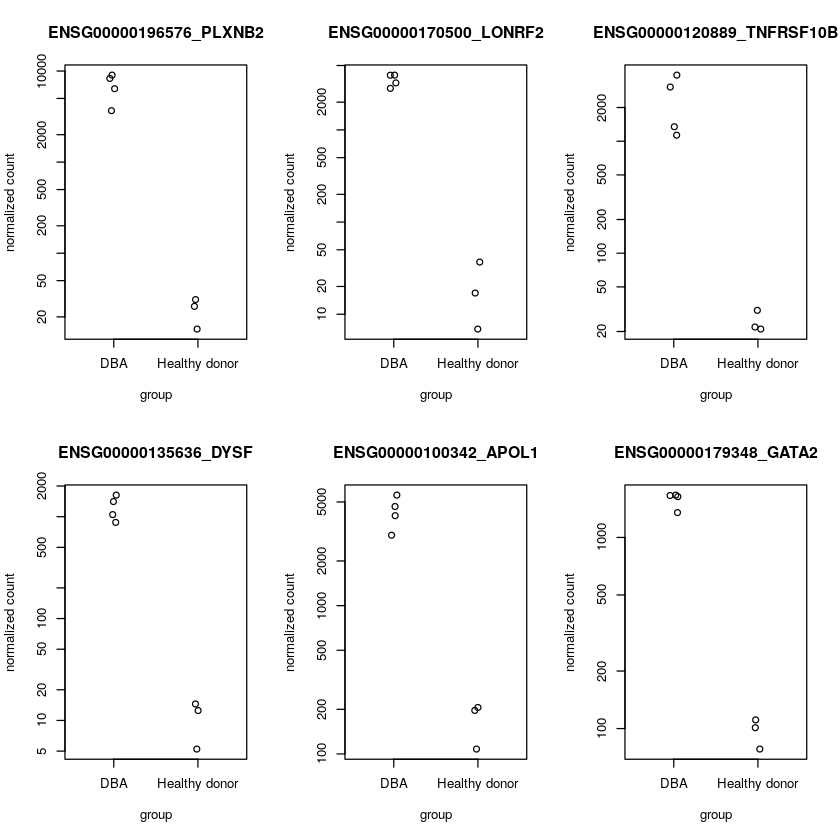

In [215]:
par(mfrow=c(2,3))

plotCounts(dds, gene="ENSG00000196576_PLXNB2", intgroup="diagnosis")
plotCounts(dds, gene="ENSG00000170500_LONRF2", intgroup="diagnosis")
plotCounts(dds, gene="ENSG00000120889_TNFRSF10B", intgroup="diagnosis")
plotCounts(dds, gene="ENSG00000135636_DYSF", intgroup="diagnosis")
plotCounts(dds, gene="ENSG00000100342_APOL1", intgroup="diagnosis")
plotCounts(dds, gene="ENSG00000179348_GATA2", intgroup="diagnosis")

## Volcano Plot

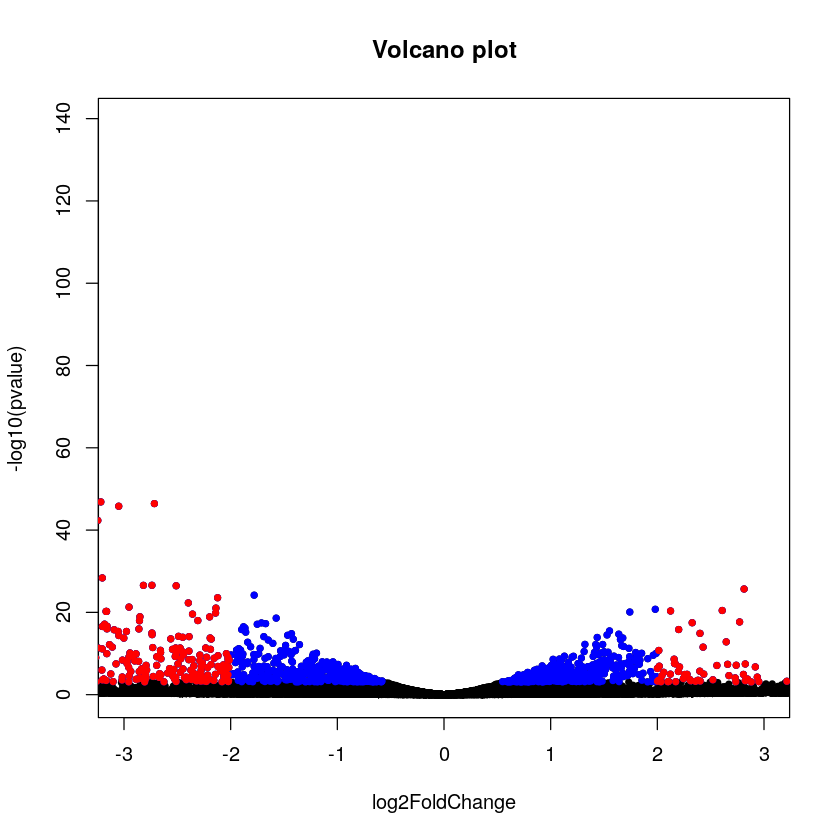

In [216]:
#reset par
par(mfrow=c(1,1))
# Make a basic volcano plot
with(res, plot(log2FoldChange, -log10(pvalue), pch=20, main="Volcano plot", xlim=c(-3,3)))

# Add colored points: blue if padj<0.01, red if log2FC>1 and padj<0.05)
with(subset(res, padj<.01 ), points(log2FoldChange, -log10(pvalue), pch=20, col="blue"))
with(subset(res, padj<.01 & abs(log2FoldChange)>2), points(log2FoldChange, -log10(pvalue), pch=20, col="red"))

## PCA

In [217]:
vsdata <- vst(dds, blind=FALSE)

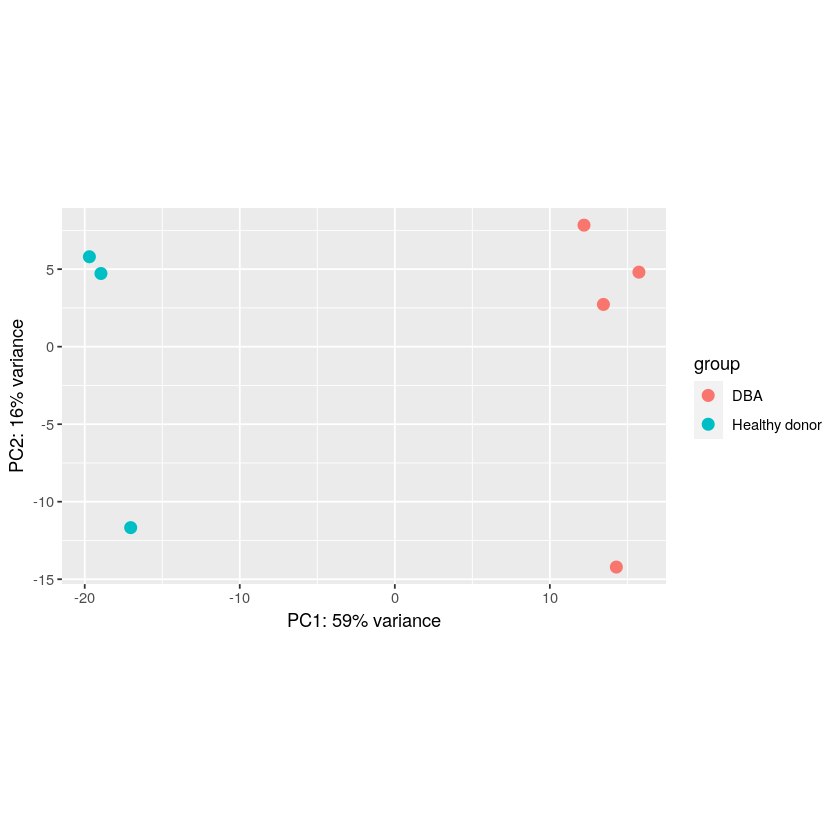

In [218]:
plotPCA(vsdata, intgroup="diagnosis") #using the DESEQ2 plotPCA fxn we can

## Validating Top Genes Observed in Analysis

### GATA2
* [Proerythroblast Cells of Diamond-Blackfan Anemia Patients With RPS19 and CECR1 Mutations Have Similar Transcriptomic Signature by Karaosmanoglu et al](https://www.frontiersin.org/articles/10.3389/fphys.2021.679919/full)

<!-- <img src="img/gata2_snippet_karaosmanoglu_et_al.png" width=1000 height=1000 /> -->

### DYSF
* [Dysferlin and Other Non-Red Cell Proteins Accumulate in the Red Cell Membrane of Diamond-Blackfan Anemia Patients by Pesciotta et al](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0085504)

<!-- <img src="img/DYSF_snippet_pesciotta_et_al.png" width=1000 height=1000 /> -->

### TNFRSF10B
* [Defective Ribosomal Protein Gene Expression Alters Transcription, Translation, Apoptosis, and Oncogenic Pathways in Diamond-Blackfan Anemia by Gazda et al](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3372914/)

<!-- <img src="img/TNFRSF10B_snippet_gazda_et_al.png" width=1000 height=1000 /> -->